<a href="https://colab.research.google.com/github/megmarv/PsychoAI-/blob/main/Custom_Made_Face_Recognition_Mode*(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Define image size
IMG_SIZE = (128, 128)

# Path to your dataset in Google Drive
DATASET_PATH = "/content/drive/My Drive/Wilder Dataset"

# Function to load and preprocess images
def load_dataset(dataset_path):
    X = []
    y = []
    class_names = sorted(os.listdir(dataset_path))  # Each folder is a class
    class_to_label = {name: idx for idx, name in enumerate(class_names)}  # Map class names to integers

    for class_name in class_names:
        class_folder = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_folder):
            print(f"Skipping non-directory: {class_folder}")
            continue
        label = class_to_label[class_name]
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            try:
                # Read and preprocess the image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Skipping invalid image: {img_path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, IMG_SIZE)  # Resize to target size
                X.append(img.astype('float32') / 255.0)  # Normalize to [0, 1]
                y.append(label)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                continue

    return np.array(X), np.array(y), class_names

# Load your dataset
X, y, class_names = load_dataset(DATASET_PATH)

print(f"Final X shape: {X.shape}")
print(f"Final y shape: {y.shape}")
print(f"Class names: {class_names}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Final X shape: (4300, 128, 128, 3)
Final y shape: (4300,)
Class names: ['0--Parade', '1--Handshaking', '10--People_Marching', '11--Meeting', '12--Group', '13--Interview', '14--Traffic', '15--Stock_Market', '16--Award_Ceremony', '17--Ceremony', '18--Concerts', '19--Couple', '2--Demonstration', '20--Family_Group', '3--Riot', '4--Dancing', '5--Car_Accident', '6--Funeral', '7--Cheering', '8--Election_Campain', '9--Press_Conference']
Training data shape: (3225, 128, 128, 3)
Testing data shape: (1075, 128, 128, 3)


In [13]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Fit the generator on training data
datagen.fit(X_train)

# Create generators for training and validation
train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_test, y_test, batch_size=32)

print("Data augmentation and generators set up successfully.")

Data augmentation and generators set up successfully.


In [16]:
# Build CNN Model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)  # RGB images
num_classes = len(class_names)

# Create and compile the model
model = build_model(input_shape, num_classes)
optimizer = SGD(learning_rate=0.01, momentum=0.9, decay=1e-6, nesterov=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Model built and compiled successfully.")
model.summary()  # Display model architecture

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model built and compiled successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21)                  │          10,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,343,317 (69.97 MB)

 Trainable params: 18,341,397 (69.97 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
# Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=25,  # <- here!
    validation_data=validation_generator,
    validation_steps=10,  # optional, or let it default
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Model training completed.")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1184 - loss: 87.4815

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - accuracy: 0.1187 - loss: 85.9787 - val_accuracy: 0.0281 - val_loss: 330.5579 - learning_rate: 0.0100
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 198s 8s/step - accuracy: 0.1235 - loss: 19.3185 - val_accuracy: 0.1250 - val_loss: 97.4864 - learning_rate: 0.0100
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.1823 - loss: 3.2415 - val_accuracy: 0.2219 - val_loss: 9.7563 - learning_rate: 0.0100
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.2171 - loss: 2.9238 - val_accuracy: 0.1969 - val_loss: 2.8572 - learning_rate: 0.0100
Epoch 5/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 3:21 8s/step - accuracy: 0.2812 - loss: 2.7816

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2812 - loss: 2.7816 - val_accuracy: 0.2438 - val_loss: 2.9975 - learning_rate: 0.0100
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 267s 10s/step - accuracy: 0.2510 - loss: 2.8648 - val_accuracy: 0.2469 - val_loss: 2.7935 - learning_rate: 0.0100
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 10s/step - accuracy: 0.2316 - loss: 2.7849 - val_accuracy: 0.2719 - val_loss: 2.6847 - learning_rate: 0.0100
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 260s 11s/step - accuracy: 0.2539 - loss: 2.7362 - val_accuracy: 0.2562 - val_loss: 2.7086 - learning_rate: 0.0100
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - accuracy: 0.1865 - loss: 2.8499 - val_accuracy: 0.2719 - val_loss: 2.6793 - learning_rate: 0.0100
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 755ms/step - accuracy: 0.1562 - loss: 2.8604 - val_accuracy: 0.2469 - val_loss: 2.7183 - learning_rate: 0.0100
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 261s 11s/step - accuracy: 0.2553 - loss: 2.6993 - val_accurac

34/34 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2170 - loss: 5.0654
Test Accuracy: 0.221395343542099
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
Precision: 0.059517961438445136
Recall: 0.056724804699798466
F1-Score: 0.031087698508885087
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       134
           1       0.25      0.04      0.06        28
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        35
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        34
          10       0.06      0.09      0.07        69
          11       0.00      0.00      0.00        29
          12       0.24      0.90      0.38       254
          13       0.00      0.00      0.00        41
          14       0.00      0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

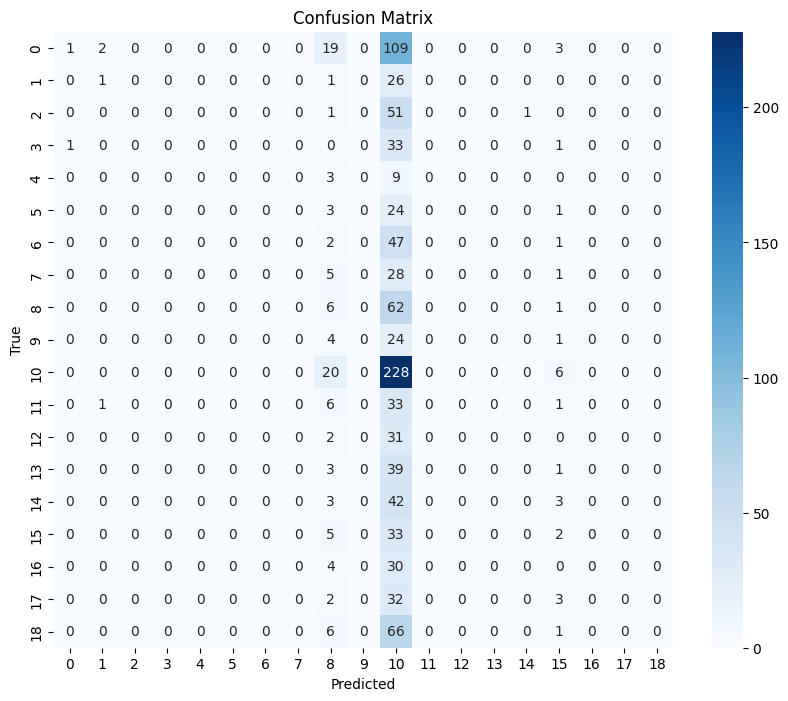

Model saved as 'face_recognition_model.h5'.


In [20]:
# Model Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Predict on test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Metrics Evaluation
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the Model
model.save("face_recognition_model.h5")
print("Model saved as 'face_recognition_model.h5'.")

In [21]:
# Function to upload and test the model (Colab-specific)
def upload_and_test_model(model):
    from google.colab import files  # Only works in Colab
    uploaded = files.upload()
    for filename in uploaded.keys():
        # Load and preprocess the image
        img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (128, 128))  # Match training size
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)  # Shape: (1, 128, 128, 3)

        # Predict
        pred = model.predict(img)
        pred_label = np.argmax(pred, axis=1)

        # Display result
        plt.imshow(cv2.cvtColor(img.squeeze(), cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted Label: {pred_label[0]}")
        plt.axis('off')
        plt.show()